In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#load datasets
resale_flats = pd.read_csv('ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv')
rent_flats = pd.read_csv('RentingOutofFlatsfromJan2021.csv')
# print(resale_flats.head())
# print(rent_flats.head())
#some data that are present in 1 dataset are not present in the other
#namely story_range, floor area, flat model, lease remaining


In [3]:
#preprocessing
#Convert month and rent_approval_date to datetime
resale_flats['month'] = pd.to_datetime(resale_flats['month'], format='%Y-%m')
rent_flats['rent_approval_date'] = pd.to_datetime(rent_flats['rent_approval_date'], format='%Y-%m')
resale_flats['lease_commence_date'] = pd.to_datetime(resale_flats['lease_commence_date'], format='%Y')
# print(resale_flats.head())
# print(rent_flats.head())

#Using towns as common key for clustering
resale_towns = resale_flats['town'].unique()
rent_towns = rent_flats['town'].unique()

# print(resale_towns)
# print(rent_towns)
#resale has Central Area which is not present in resale_towns (central) 
#So we will replace Central Area with Central in resale_flats
resale_flats['town'] = resale_flats['town'].str.strip() #remove leading/trailing spaces
resale_flats['town'] = resale_flats['town'].str.upper() #convert to uppercase for uniformity
#replace ' ROOM' within resale_flats to '-ROOM'
resale_flats['flat_type'] = resale_flats['flat_type'].str.replace(' ROOM', '-ROOM')
# print(resale_flats['flat_type'].unique())


rent_flats['town'] = rent_flats['town'].str.strip()
rent_flats['town'] = rent_flats['town'].str.upper()
resale_flats['town'] = resale_flats['town'].str.replace('CENTRAL AREA', 'CENTRAL')
#resale_towns does not have TENGAH but rent_towns has TENGAH
#we will not use tengah in our analysis as a result (total 25 towns)
common_towns = set(resale_towns).intersection(set(rent_towns))
print(common_towns)
print(len(common_towns))
#drop rows with towns not in common_towns, these will be used as a direct comparison
resale_flats_clean = resale_flats[resale_flats['town'].isin(common_towns)] 
rent_flats_clean = rent_flats[rent_flats['town'].isin(common_towns)]



{'BISHAN', 'BUKIT MERAH', 'SERANGOON', 'GEYLANG', 'PASIR RIS', 'SENGKANG', 'MARINE PARADE', 'JURONG EAST', 'CLEMENTI', 'KALLANG/WHAMPOA', 'WOODLANDS', 'BUKIT PANJANG', 'TOA PAYOH', 'ANG MO KIO', 'HOUGANG', 'CHOA CHU KANG', 'TAMPINES', 'SEMBAWANG', 'PUNGGOL', 'BUKIT BATOK', 'BEDOK', 'BUKIT TIMAH', 'QUEENSTOWN', 'JURONG WEST', 'YISHUN'}
25


         town flat_type      month  resale_price rent_approval_date  \
0  ANG MO KIO    2-ROOM 2021-01-01      218000.0         2021-01-01   
1  ANG MO KIO    2-ROOM 2021-04-01      213250.0         2021-04-01   
2  ANG MO KIO    2-ROOM 2021-05-01      230000.0         2021-05-01   
3  ANG MO KIO    2-ROOM 2021-07-01      230000.0         2021-07-01   
4  ANG MO KIO    2-ROOM 2021-09-01      233000.0         2021-09-01   

   monthly_rent  price_rent_ratio  
0        1475.0         12.316384  
1        1100.0         16.155303  
2        1000.0         19.166667  
3        1425.0         13.450292  
4        1775.0         10.938967  


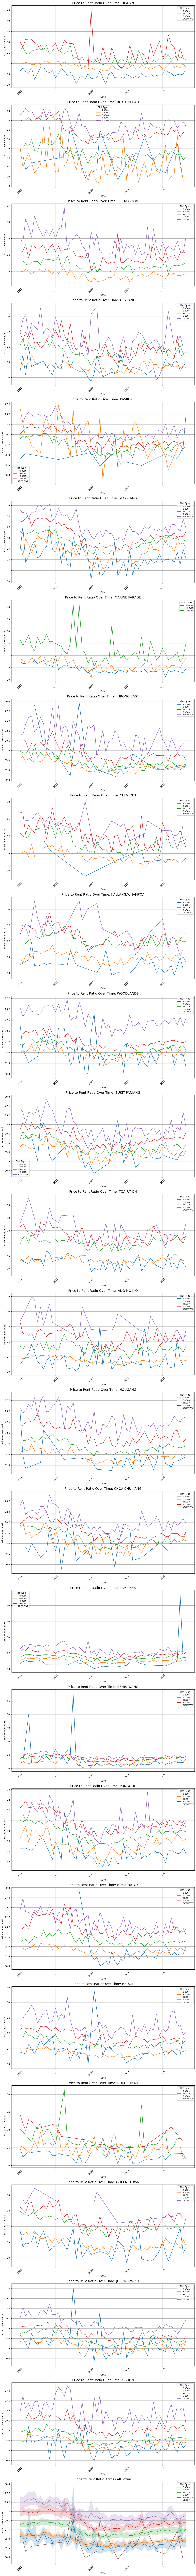

In [13]:
#Find average resale price and rent price per town for each year, grouped by flat_type
average_resale_prices = resale_flats_clean.groupby([ 'town','flat_type', 'month'])['resale_price'].mean().reset_index()
average_rent_prices = rent_flats_clean.groupby(['town','flat_type', 'rent_approval_date'])['monthly_rent'].mean().reset_index()
#print(average_resale_prices.head())
#print(average_rent_prices.head())
price_rent_ratio = pd.merge(average_resale_prices, average_rent_prices, left_on=[ 'town','flat_type', 'month'], right_on=[ 'town','flat_type', 'rent_approval_date'], how='inner')
#print(price_rent_ratio)
price_rent_ratio['price_rent_ratio'] = price_rent_ratio['resale_price'] / (price_rent_ratio['monthly_rent'] * 12)
print(price_rent_ratio.head())
#Visualize the price to rent ratio for each flat_type in each town over time

# Create a figure and a grid of subplots (one per town + one additional plot for all towns)
fig, axes = plt.subplots(len(common_towns) + 1, 1, figsize=(12, 6 * (len(common_towns) + 1)))

# Loop through each town and plot its data in the respective subplot
for i, town in enumerate(common_towns):
    town_data = price_rent_ratio[price_rent_ratio['town'] == town]
    
    ax1 = axes[i]
    
    # Use seaborn lineplot with hue to automatically differentiate flat_types
    sns.lineplot(data=town_data, x='month', y='price_rent_ratio', 
                 ax=ax1, hue='flat_type', palette="tab10")
    
    ax1.set_title(f'Price to Rent Ratio Over Time: {town}', fontsize=14)
    ax1.set_xlabel('Date', fontsize=10)
    ax1.set_ylabel('Price to Rent Ratio', fontsize=10)
    ax1.tick_params(axis='x', rotation=45)
    ax1.legend(title='Flat Type', fontsize=8)
    
    # Add grid for better visualization
    ax1.grid(True)

# Plot for all towns (aggregate by flat_type across all towns)
ax_all_towns = axes[-1]

# Group the data by flat_type and plot the price to rent ratio for each flat type across all towns
sns.lineplot(data=price_rent_ratio, x='month', y='price_rent_ratio', 
             ax=ax_all_towns, hue='flat_type', palette="tab10")

ax_all_towns.set_title('Price to Rent Ratio Across All Towns', fontsize=14)
ax_all_towns.set_xlabel('Date', fontsize=10)
ax_all_towns.set_ylabel('Price to Rent Ratio', fontsize=10)
ax_all_towns.tick_params(axis='x', rotation=45)
ax_all_towns.legend(title='Flat Type', fontsize=8)

# Add grid for better visualization
ax_all_towns.grid(True)

# Adjust layout so everything fits
plt.tight_layout()

# Show the plot
plt.show()


In [14]:
#Logistic Regression to predict price of flats based on features
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
# Prepare the data

